In [6]:
import os, sys, pickle
%pylab inline
plt.style.use("default")
# Turn off top and right spines
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['figure.figsize'] = (8, 3)

Populating the interactive namespace from numpy and matplotlib


# Preprocessing

In [134]:
data = pickle.load(open("data/striatum-data.p", "rb"))

In [135]:
trials      = data["trials_indices"]
neurons     = data["neurons"].values
spike_times = data["spikes_times"]
trial_starts   = data["trials_start_times"]
trial_ends     = data["trials_end_times"]
trial_lengths  = trial_ends - trial_starts
earliest_spike = min([min(concatenate([neuron for neuron in trial])) for trial in spike_times])
latest_spike   = max([max(concatenate([neuron for neuron in trial])) for trial in spike_times])

In [136]:
spikes_dict = {itrial:{ineuron: spike_times[itrial][ineuron] for ineuron, neuron in enumerate(neurons)} for itrial, trial in enumerate(trials)}

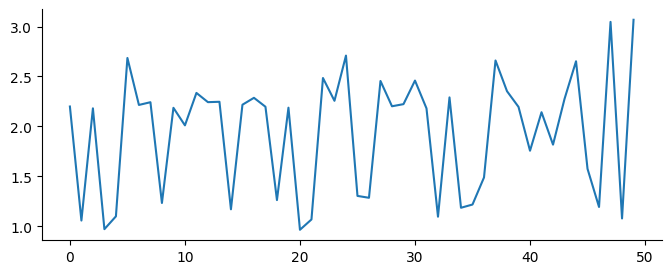

In [137]:
plot(trial_lengths)

In [138]:
long_trials = where(trial_lengths > 2)[0]

In [139]:
neuron_colors = [cm.rainbow(rand()) for _ in range(len(neurons))]
neuron_colors = [cm.rainbow(0.5*(i % 2) + 0.5*i/len(neurons)) for i in range(len(neurons))]

In [140]:
def plot_raster(spike_times, which_trials, which_neurons, trials_first = False, subtract_trial_start = False, t_min = earliest_spike - 0.25, t_max = latest_spike + 0.25,
                neuron_colors = neuron_colors,
                spike_gap = 0.1,
                trial_gap = 0.1,
                ylab_fontsize = 8,
                ):
    # Iterate through trials and neurons
    inner_loop = which_trials  if trials_first else which_neurons
    outer_loop = which_neurons if trials_first else which_trials
    iplt = 0
    h_spike = 1 - spike_gap
    h_trial = 1 - trial_gap
    labs = []
    for ind_out in outer_loop:
        for ind_in in inner_loop:
            neuron, trial = (ind_out, ind_in) if trials_first else (ind_in, ind_out)
            labs.append(f"{neuron}:{trial}")
            # Get spike times
            t_spikes    = spike_times[trial][neuron] - subtract_trial_start * trial_starts[trial]
            trial_start = trial_starts[trial]        - subtract_trial_start * trial_starts[trial]
            trial_end   = trial_ends[trial]          - subtract_trial_start * trial_starts[trial]
            # Plot the trial
            plt.fill_between([trial_start, trial_end], [iplt - h_trial/2, iplt - h_trial/2], [iplt + h_trial/2, iplt + h_trial/2], color="darkgray", alpha=0.3, edgecolor="black")
            # Plot spikes
            plt.plot([t_spikes, t_spikes], [(iplt-h_spike/2) + 0*t_spikes,(iplt+h_spike/2)+0*t_spikes], lw=1, color = neuron_colors[neuron])
            iplt += 1
    # Set the axis background color to black
    gca().set_facecolor('black')
    ylim(-1, iplt)
    gca().set_yticks(arange(iplt), labs, fontsize=ylab_fontsize)
    xlabel("Time (s)" if not subtract_trial_start else "Time from trial start (s)")
    ylabel("Neuron:trial")

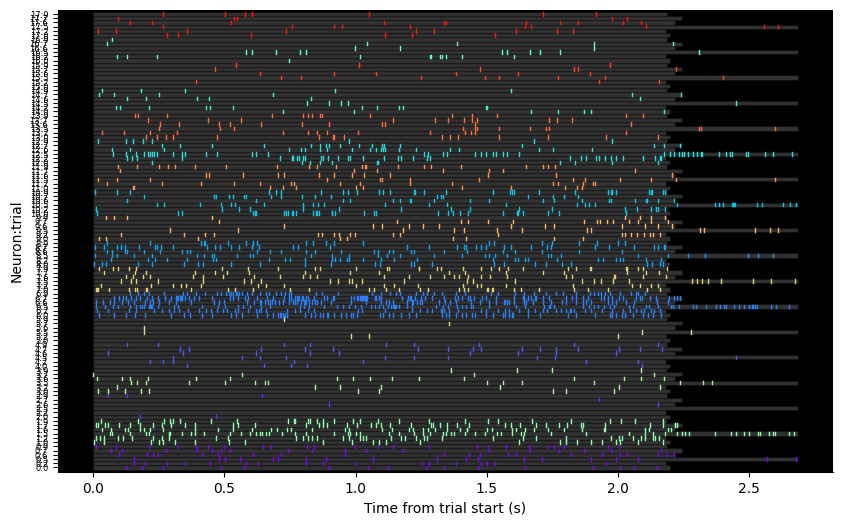

In [145]:
which_trials = long_trials[0:6]
figure(figsize=(10,1 * len(which_trials)))
plot_raster(spike_times, which_trials =which_trials, which_neurons = range(len(neurons)), trials_first = True, subtract_trial_start = True, spike_gap = 0.2, trial_gap = 0, ylab_fontsize = 6)

## Bin spike times

In [148]:
bin_res = 0.01
window_size = 0.1
t_min   =  -0.5
t_max   = 2
bins    = arange(t_min, t_max, bin_res)
binned_spikes = np.zeros((len(trials), len(neurons), len(bins)-1))
for itrial, trial in enumerate(trials):
    for ineuron, neuron in enumerate(neurons):
        for ibin in range(len(bins)-1):
            binned_spikes[itrial, ineuron, ibin] = sum((bins[ibin] <= spike_times[itrial][ineuron]) & (spike_times[itrial][ineuron] < bins[ibin]+window_size))

In [149]:
X = binned_spikes[long_trials]
t = bins[:-1] + window_size/2

# Practical

In [150]:
print(X.shape) # (n_trials, n_neurons, n_bins)

(31, 18, 249)


In [151]:
Xm = X.mean(axis=0)

Text(0.5, 0, 'Time bin')

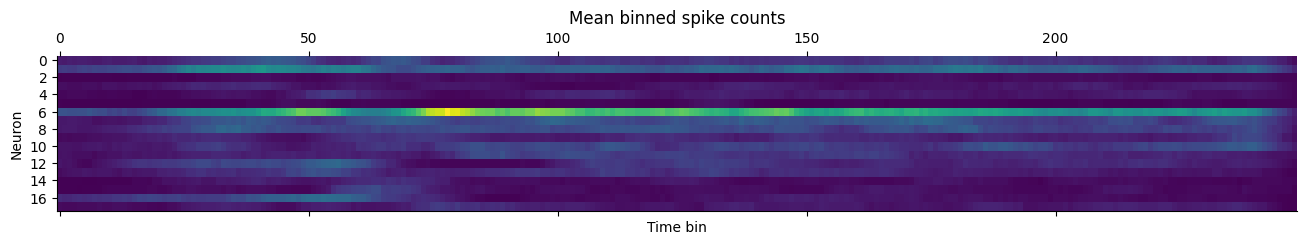

In [153]:
matshow(Xm); axis("auto")
title("Mean binned spike counts")
ylabel("Neuron")
xlabel("Time bin")

In [154]:
Xm_mean = Xm.mean(axis=1)
Xms= Xm - Xm_mean[:, np.newaxis]

In [155]:
U,s,Vt = np.linalg.svd(Xms, full_matrices=False)
print(U.shape, s.shape, Vt.shape)

(18, 18) (18,) (18, 249)


Text(0, 0.5, 'Cumulative explained variance')

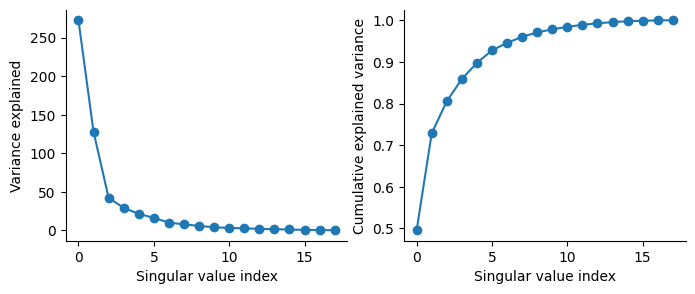

In [156]:
subplot(121); plot(s**2, "o-"); xlabel("Singular value index"); ylabel("Variance explained")
subplot(122); plot((s**2).cumsum()/(s**2).sum(), "o-"); xlabel("Singular value index"); ylabel("Cumulative explained variance")


## Plot trajectories

In [157]:
Y = diag(s[:2]) @ Vt[:2,:]
t = bins[:-1]

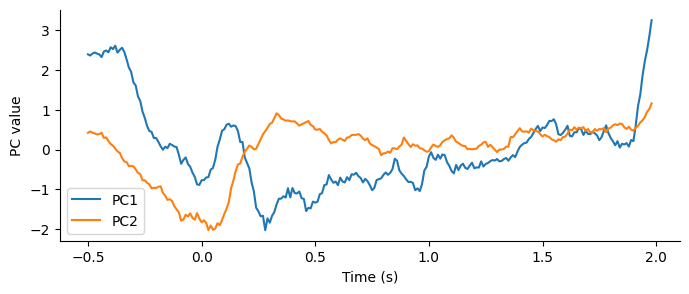

In [158]:
plot(t, Y[0], label="PC1")
plot(t,  Y[1], label="PC2")
xlabel("Time (s)")
ylabel("PC value")
legend()


Text(0, 0.5, 'PC2')

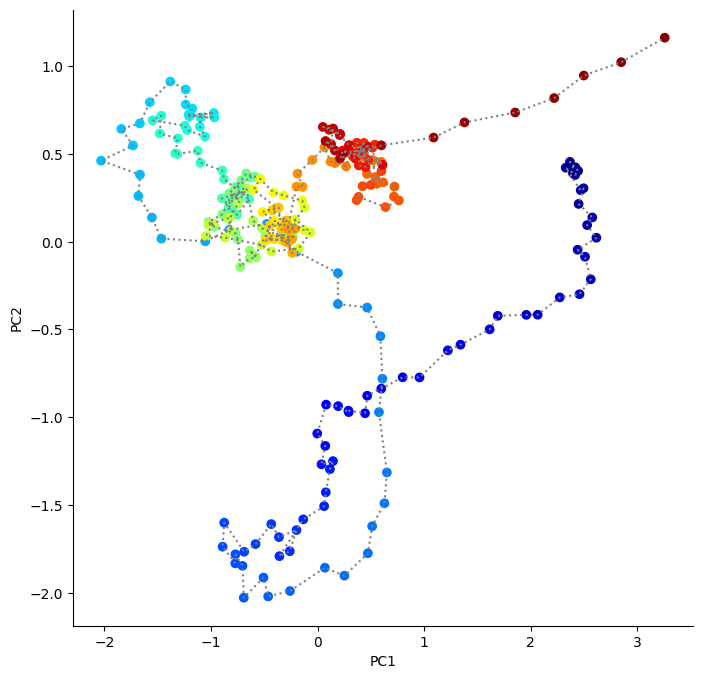

In [159]:
figure(figsize=(8, 8))
cmap = cm.jet
plot(Y[0], Y[1], ":", color="gray")
scatter(Y[0], Y[1], c=[cmap(i/float(len(Y[0]))) for i in range(len(Y[0]))])
xlabel("PC1")
ylabel("PC2")

## Reconstruction

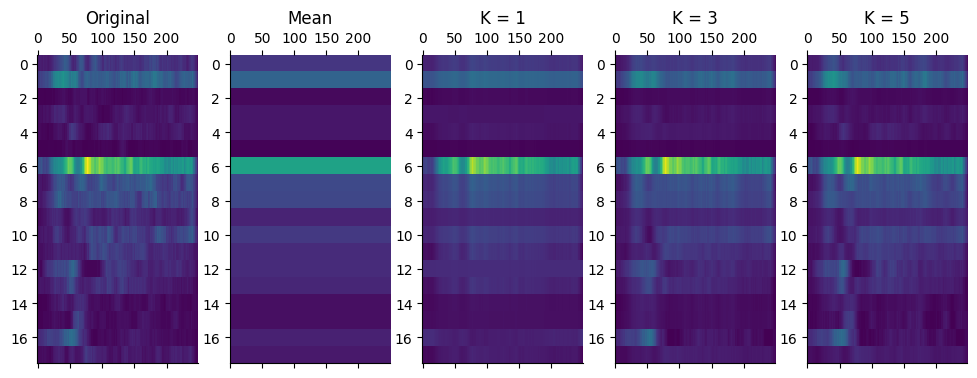

In [160]:
n_cmps = [1,3,5]
figure(figsize=(12, 4))
subplot(151); matshow(Xm, aspect="auto", fignum=False); title("Original")
# Get vmin and vmax for all plots
vmin, vmax = gci().get_clim()
subplot(152); matshow(outer(Xm_mean, ones(len(bins))), aspect="auto", fignum=False, vmin=vmin, vmax=vmax);
title("Mean")
for i, n_cmp in enumerate(n_cmps):
    Xrec = (U[:,:n_cmp] @ np.diag(s[:n_cmp]) @ Vt[:n_cmp,:]) + Xm_mean[:, np.newaxis]
    subplot(1, 5, i+3); matshow(Xrec, aspect="auto", fignum=False, vmin=vmin, vmax=vmax); title(f"K = {n_cmp}")

